# **1️⃣ Load & Explore the Data**
This section loads the `bank-full.csv` dataset and checks for missing values, column types, and overall data structure.


In [30]:
import pandas as pd

# Load the dataset (make sure the file path is correct)
file_path = "../data/raw/bank/bank-full.csv"
df = pd.read_csv(file_path, delimiter=";")  # The dataset uses ";" as the delimiter

# Display basic info about the dataset (column names, data types, missing values)
df.info()

# Preview the first few rows of the dataset
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# **2️⃣ Data Preprocessing**
Now we clean the dataset by:
1. Converting categorical "yes/no" values into binary (0/1).
2. One-hot encoding other categorical variables.
3. Normalizing numerical features for better model performance.
4. Checking for class imbalance in the target variable (`y`).


In [31]:
# Convert categorical 'yes/no' columns to binary values (0 for "no", 1 for "yes")
binary_cols = ["default", "housing", "loan", "y"]
df[binary_cols] = df[binary_cols].replace({"yes": 1, "no": 0})


In [32]:
# List of categorical columns to be one-hot encoded
categorical_cols = ["job", "marital", "education", "contact", "month", "poutcome"]

# Apply one-hot encoding and drop the first column to avoid dummy variable trap
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Define numerical columns that need normalization
num_cols = ["balance", "duration", "campaign", "pdays", "previous"]

# Apply Min-Max Scaling (scales data between 0 and 1)
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [34]:
# Get the percentage distribution of classes in target variable y (response to marketing)
class_distribution = df["y"].value_counts(normalize=True) * 100
print("Class Distribution:\n", class_distribution)


Class Distribution:
 y
0    88.30152
1    11.69848
Name: proportion, dtype: float64


# **3️⃣ Propensity Score Modeling**
Instead of just predicting "yes" or "no," we estimate **the likelihood** of a customer responding positively.
- A **logistic regression model** is trained to generate **propensity scores**.
- These scores represent the probability of each customer saying **"yes"**.


In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError

# Load dataset
file_path = "/Users/abhiramp/Development/Project/bias-mitigation-bank-marketing-ML/data/raw/bank/bank-full.csv"
df = pd.read_csv(file_path, sep=";")

# Define treatment variable (binary variable based on balance threshold)
balance_threshold = df['balance'].median()  # Use median as threshold
df['treatment'] = (df['balance'] > balance_threshold).astype(int)

# Define covariates (excluding target variable 'y' and 'balance' to prevent leakage)
features = ['age', 'job', 'education', 'marital', 'default', 'housing', 'loan', 'campaign', 'previous']

# Drop rows with missing values in required features
ohe = df.dropna(subset=features)

# Convert categorical variables into dummies, handling unknowns
df_temp = pd.get_dummies(ohe, columns=['job', 'education', 'marital', 'default', 'housing', 'loan'], drop_first=True)

# Ensure all features are numeric
non_numeric_cols = df.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Warning: Non-numeric columns detected: {non_numeric_cols}. Dropping them.")
    df_temp = df.drop(columns=non_numeric_cols)  # Drop non-numeric columns

# Standardize numerical features
scaler = StandardScaler()
num_features = ['age', 'campaign', 'previous']
df_temp[num_features] = scaler.fit_transform(df_temp[num_features])

# Fit logistic regression model for propensity score estimation
X = df_temp.drop(columns=['balance', 'treatment', 'y'], errors='ignore')  # Exclude balance, treatment, and target variable
y = df_temp['treatment']

# Ensure there are no remaining object columns
if X.select_dtypes(include=['object']).shape[1] > 0:
    raise ValueError("Some categorical features are not properly encoded. Check dataset preprocessing.")

logit_model = LogisticRegression()
logit_model.fit(X, y)

# Compute propensity scores (probability of receiving treatment)
df_temp['propensity_score'] = logit_model.predict_proba(X)[:, 1]

from IPython.display import display

# Show the first 10 rows of relevant columns
display(df_temp[['balance', 'treatment', 'propensity_score']].head(10))



       'month', 'poutcome', 'y'],
      dtype='object'). Dropping them.


,balance,treatment,propensity_score
0,2143,1,0.569024
1,29,0,0.496966
2,2,0,0.441153
3,1506,1,0.506144
4,1,0,0.450436
5,231,0,0.454999
6,447,0,0.429342
7,2,0,0.505449
8,121,0,0.553023
9,593,1,0.485005


- A score close to 1 means the customer has characteristics strongly associated with having a high balance.
- A score close to 0 means the customer has characteristics associated with having a low balance.
- A score around 0.5 suggests that the customer could belong to either group with nearly equal probability.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


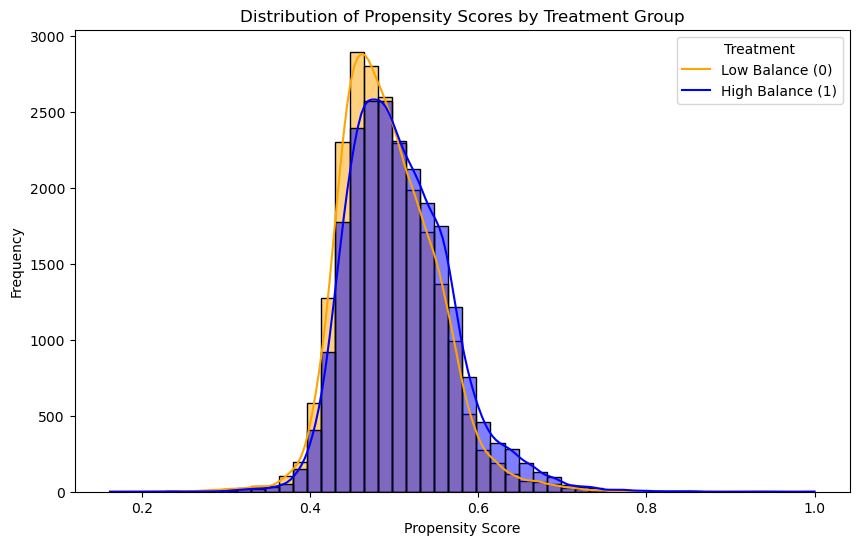

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'treatment' is categorical
df_temp['treatment'] = df_temp['treatment'].astype(str)  # Convert to string for categorical hue

# Plot the histogram of propensity scores with hue by treatment group
plt.figure(figsize=(10, 6))
sns.histplot(df_temp, x='propensity_score', kde=True, bins=50, hue='treatment', palette=['blue', 'orange'])
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend(title='Treatment', labels=['Low Balance (0)', 'High Balance (1)'])
plt.show()


## Understanding the Propensity Score Distribution

This plot shows the **distribution of propensity scores** for two groups:

- **High balance group (blue)**
- **Low balance group (orange)**

### Key Takeaways

1. **Overlap Between Groups**  
   - The two distributions overlap significantly, which is a good sign.  
   - This means customers in both groups share similar characteristics, making fair comparisons possible.  

2. **Shape of the Distribution**  
   - Customers with a **low balance** tend to have lower propensity scores (around 0.3 to 0.5).  
   - Customers with a **high balance** are slightly shifted toward higher scores (around 0.4 to 0.6).  
   - There are very few extreme scores (<0.2 or >0.8), meaning most customers have a moderate likelihood of being in either group.

3. **Why This Matters**  
   - Since there's good overlap, we can proceed with **Propensity Score Matching (PSM)** to create comparable groups.  
   - This will help us analyze the effect of having a high balance while reducing bias.

### Next Steps

- **Perform Propensity Score Matching (PSM)** to ensure we are comparing similar individuals.
- **Check if the matched groups are balanced** across key f


 ### Evaluate the Impact of Balance on the Target Variable 

In [55]:
# Convert 'y' column to numeric (1 for 'yes', 0 for 'no')
if 'y' in df.columns:
    df['y'] = df['y'].map({'yes': 1, 'no': 0})
else:
    raise KeyError("Target variable 'y' not found in dataset. Check column names.")

# Define predictor variables
import statsmodels.api as sm
X = df_temp[['treatment', 'propensity_score']]
X = sm.add_constant(X)  # Add intercept

# Define target variable
y = df['y']

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Load dataset
file_path = "/Users/abhiramp/Development/Project/bias-mitigation-bank-marketing-ML/data/raw/bank/bank-full.csv"
df = pd.read_csv(file_path, sep=";")  # Original dataframe remains unchanged

# Create a copy of the dataframe to prevent modification of the original
df_temp = df.copy()

# Define treatment variable (binary variable based on balance threshold)
balance_threshold = df_temp['balance'].median()  # Use median as threshold
df_temp['treatment'] = (df_temp['balance'] > balance_threshold).astype(int)

# Define covariates (excluding target variable 'y' and 'balance' to prevent leakage)
features = ['age', 'job', 'education', 'marital', 'default', 'housing', 'loan', 'campaign', 'previous']

# Drop rows with missing values in required features
df_temp = df_temp.dropna(subset=features)

# Convert categorical variables into dummies, handling unknowns
df_temp = pd.get_dummies(df_temp, columns=['job', 'education', 'marital', 'default', 'housing', 'loan'], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
num_features = ['age', 'campaign', 'previous']
df_temp[num_features] = scaler.fit_transform(df_temp[num_features])

# Fit logistic regression model for propensity score estimation
X = df_temp.drop(columns=['balance', 'treatment', 'y'], errors='ignore')  # Exclude balance, treatment, and target variable
y = df_temp['treatment']

# Ensure there are no remaining object columns
if X.select_dtypes(include=['object']).shape[1] > 0:
    raise ValueError("Some categorical features are not properly encoded. Check dataset preprocessing.")

logit_model = LogisticRegression()
logit_model.fit(X, y)

# Compute propensity scores (probability of receiving treatment)
df_temp['propensity_score'] = logit_model.predict_proba(X)[:, 1]

# Display first 10 rows of propensity score results
display(df_temp[['balance', 'treatment', 'propensity_score']].head(10))

# Ensure 'treatment' is categorical
df_temp['treatment'] = df_temp['treatment'].astype(str)  # Convert to string for categorical hue

# Plot the histogram of propensity scores with hue by treatment group
plt.figure(figsize=(10, 6))
sns.histplot(df_temp, x='propensity_score', kde=True, bins=50, hue='treatment', palette=['blue', 'orange'])
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend(title='Treatment', labels=['Low Balance (0)', 'High Balance (1)'])
plt.show()

# Convert 'y' column to numeric in df_temp without modifying original df
if 'y' in df_temp.columns:
    df_temp['y'] = df_temp['y'].map({'yes': 1, 'no': 0})
else:
    raise KeyError("Target variable 'y' not found in dataset. Check column names.")

# Define predictor variables
X = df_temp[['treatment', 'propensity_score']]
X = sm.add_constant(X)  # Add intercept

# Define target variable
y = df_temp['y']

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


ValueError: Some categorical features are not properly encoded. Check dataset preprocessing.